# `maps`: molecular als phenotype scores
This vignette outlines basic setup and usage for the molecular als phenotype scores (MAPs) pipeline described in Kumbier et al. 2024. Currently, the pipeline supports imaging-based phenotype analysis. However, the pipeline design is fairly modular and can be readily extended to incorporate new data modalities.

## Installation
`maps` can be installed directly from this repository using the steps below. A Python virtual environment (venv) creates a self-contained environment that isolates any changes from system level configuration. It is highly recommended that you install `maps` within a virtual environment to avoid any unexpected dependency or version issue.

```
git clone git@github.com:karlkumbier/maps.git
cd maps

python3 -m venv .venv
source .venv/bin/activate

pip install maps
```

### Analysis `params`
To help ensure reproducibility, the `maps` pipeline is organized around parameter (json) files. Parameter files define complete analytical workflows including: which data are used, how data are pre-processed, what quality control analyses are performed, what model is used for classification, and what post-hoc summaries of the model are performed. The `maps` pacakge implements classes for parsing these parameter files and carying out specified analyses. Any analysis can be explicitly reproduced given its parameter file.

**Analysis metadata params**

- `name`: user-defined name for the analysis.
- `root`: root directory (i.e., where all screen subdirectories are stored).
- `screen`: screen identifier, specifying the experiment in which the data were generated. Typically, a screen corresponds to cell lines culturued and processed simultaneously. 
- `eval_dir`: subdirectory of each plate directory containing data used in the analysis. Typically, this should be set as "Evaluation1" but may be changed if e.g., multiple imaging rounds were performed for the same plate.
- `data_file`: name of data file containing molecular profiles (e.g., imaging features)

**Additional analysis params**
- `preprocess`: dict specifying all preprocessing functions to be performed. The entries of this dict should be key-value pairs, keys indicating the name of preprocessing function to be performed (see `maps.preprocess`) and values a dict of kwargs for that function.
- `eda`: dict specifying exploratory data analysis figures to be generated. The entries of this dict should be key-value pairs, keys indicating the name of eda function to be performed (see `maps.eda`) and values a dict of kwargs for that function. 
- `analysis`: dict specifying all analyses to be performed. The entries of this dict should be key-value pairs, keys indicating the name of the analysis to be performed (see `maps.analyses`) and values a dict of kwargs for that analysis.


In [2]:
import json

with open("./params.json", "r") as f:
    params = json.load(f)
 
print(json.dumps(params, indent=4))

{
    "name": "vignette_example",
    "root": "/home/kkumbier/als",
    "screen": "20250216_AWALS37_Full_screen_n96",
    "eval_dir": "Evaluation1",
    "data_file": "Objects_Population - Nuclei Selected.txt",
    "preprocess": {
        "drop_na_features": {
            "na_prop": 0.1
        },
        "select_sample_by_feature": {
            "select_key": [
                {
                    "Drugs": [
                        "DMSO"
                    ]
                },
                {
                    "Mutations": [
                        "WT",
                        "C9orf72"
                    ]
                }
            ]
        },
        "select_feature_types": {
            "feature_str": "^.*Intensity.*$|^.*Spot.*$"
        },
        "drop_feature_types": {
            "feature_str": "^.*Sum$"
        },
        "drop_constant_features": {}
    },
    "analysis": {
        "PCAnalysis": {
            "components": [
                1,
                2
 

### Screens
The `*Screen` classes provide the basic containers for loading and processing data / metadata. Data are loaded based on files / paths defined in `params` by calling `<screen>.load`. Calling `<screen>.preprocess` iterates over each preprocessing function defined in `params` and applies that function to the screen data / metadata.

To enable extension to future data modalities, we defined the `ScreenBase` class to handle basic functionality around calling modules from the `maps` package (see `maps.screens`). Modality specific subclasses (e.g., `ImageScreen`) handle specifics around data I/O that are unique to each modality. For example, imaging profiles are derived from specific antibodies. Since a single screen may contain data for multiple antibodies, we allow antibodies to be explicitly defined when calling load (see below) *or* the `antibody` key may be defined in the params file.

In [3]:
from maps.screens import ImageScreen
from maps.processing import *

screen = ImageScreen(params)
screen.load(antibody="COX IV/Galectin3/atubulin")

print(screen.data.head())
print(screen.metadata.head())

screen.preprocess()

E0000 00:00:1741136988.492636 2476012 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741136988.531747 2476012 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


shape: (5, 4_763)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ Total_Spo ┆ Relative_ ┆ Number_of ┆ Number_of ┆ … ┆ Membrane_ ┆ Membrane_ ┆ Membrane_ ┆ ID       │
│ t_Area    ┆ Spot_Inte ┆ _Spots    ┆ _Spots_pe ┆   ┆ Region_Al ┆ Region_Al ┆ Region_Al ┆ ---      │
│ ---       ┆ nsity     ┆ ---       ┆ r_Area_of ┆   ┆ exa_647_H ┆ exa_647_G ┆ exa_647_G ┆ str      │
│ f32       ┆ ---       ┆ f32       ┆ _Ce…      ┆   ┆ ara…      ┆ abo…      ┆ abo…      ┆          │
│           ┆ f32       ┆           ┆ ---       ┆   ┆ ---       ┆ ---       ┆ ---       ┆          │
│           ┆           ┆           ┆ f32       ┆   ┆ f32       ┆ f32       ┆ f32       ┆          │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ 106.0     ┆ 0.049825  ┆ 5.0       ┆ 0.002924  ┆ … ┆ 0.258299  ┆ 0.001769  ┆ 0.010958  ┆ 20240420 │
│           ┆           ┆           ┆           ┆   ┆           ┆        

### Exploratory data analysis (EDA) 
Functions for generating common EDA / quality control figures are defined in `maps.eda`. A list of figures to be generated can be specified in `params`, and subsequently generated by calling `screen.eda`. Alternatively, these functions can be called directly on a `BaseScreen` object. 

/home/kkumbier/als/.venv/lib/python3.12/site-packages/maps/eda.py:70: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


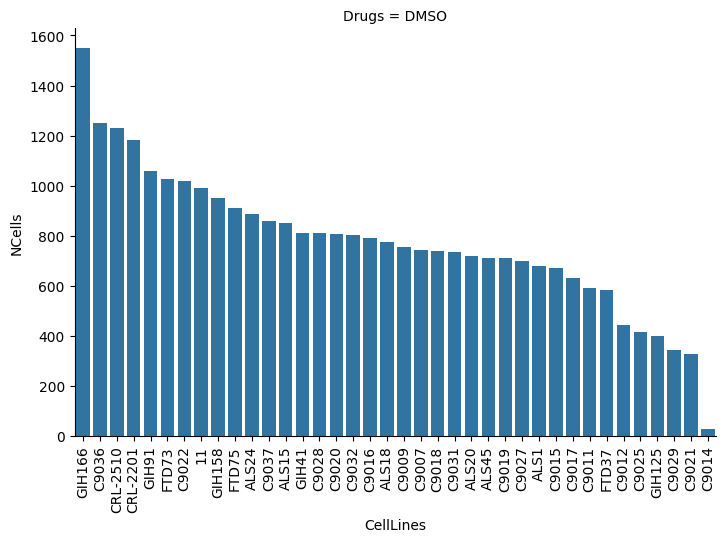

In [ ]:
from maps.eda import plot_cell_count

plt = plot_cell_count(screen)
plt.show()

In the figure above, we notice C9014 has an unusually low cell count. We can drop this cell line from our screen using the `maps.preprocess.drop_sample_by_feature` function. Note that if we knew *a priori* that we wanted to drop C9014, we could also specify this preprocessing step in the `params` file.

/home/kkumbier/als/.venv/lib/python3.12/site-packages/maps/eda.py:70: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


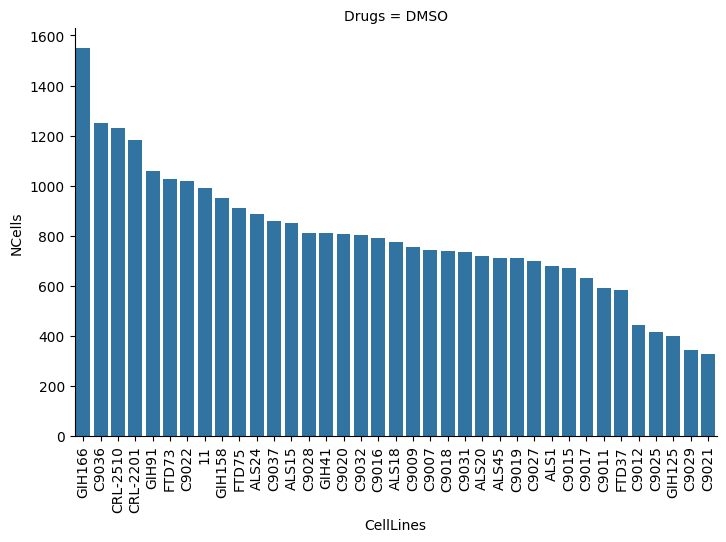

In [6]:
screen = drop_sample_by_feature(screen, drop_key=[{"CellLines": ["C9014"]}])

plt = plot_cell_count(screen)
plt.show()

Functions for running and visualizing PCA results are also available in `maps.eda`. These can be called directly on a `BaseScreen` object. PCA is performed on molecular profiles (e.g., imaging features) averaged at the level of `ID`. In the case of imaging data, this corresponds to averaging single cell measurements within each imaging well.

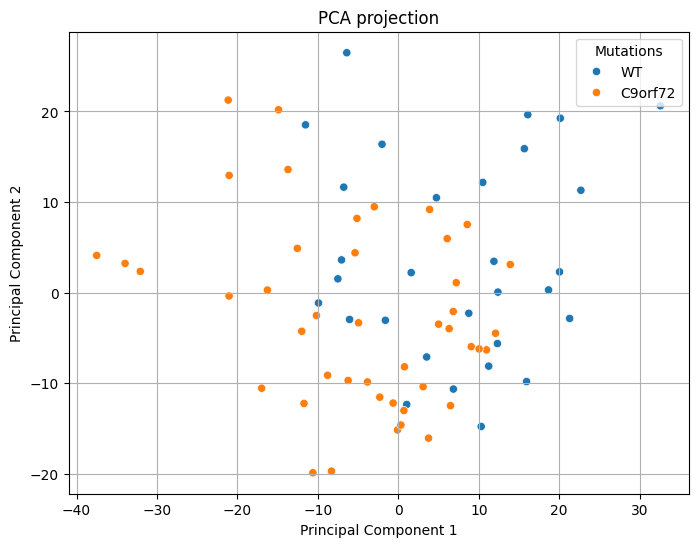

In [7]:
from maps.eda import pca, plot_pca

pca_df = pca(screen)
plt = plot_pca(pca_df, screen)
plt.show()


### MAP score analysis
The `MAP` analysis class provides the core functionality for computing MAP scores. MAP scores are essentially predicted probabilities from classification models trained to differentiate selected ALS subgroups from healthy controls. Scores are always generated for cell lines held-out from model training. The `MAP` class provides the flexibility to define:

#### Models
The specific model used for classification can be one defined in `maps.models` or a new user-defined model. User-defined models should extend the `BaseModel` class and implement functions: `fit_` (returning a fitted model), `predict_` (returning model predicted probabilities), and `importance_` (returning model feature importances).

#### Fitters
Fitters define how data should be split for training MAP models and evaluating MAP scores (i.e., test set data). These functions operate on a `*Screen` and `BaseModel`, split data according to user specifications, train model(s) on the resulting split data, and generate MAP scores from fitted models.

Both models and fitters should be defined in `params`. In this example, we use the `Delearner` model: a two-layer FCNN with a binary cross entropy loss (to predict classes) and negative gradient MSE loss (to de-learn cell count). Additional parameters for this model (e.g., epochs and batch size) are specified in `params`. We use the `sample_split` fitter, which splits cell lines into two equally sized groups, trains a model on single cell measurements for each group of cell lines, and evaluates predictions on the hold-out set of cell lines. The figure below shows MAP scores averaged within each cell line.


In [ ]:
from maps.fitters import *
from maps.analyses import MAP
from maps.models import Delearner
plt = plot_cell_count(screen)
plt.show()

map_analysis = MAP(screen)
map_analysis.fit()

plt = map_analysis.make_fig()
plt.show()

W0000 00:00:1741138914.711317 2476012 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Epoch 1/5
306/306 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - delearning_head_cor: -8.2503e-09 - delearning_head_loss: 99.8670 - learning_head_accuracy: 0.6433 - learning_head_loss: 0.6385 - loss: 1.6372
Epoch 2/5
306/306 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - delearning_head_cor: -2.6494e-08 - delearning_head_loss: 99.4798 - learning_head_accuracy: 0.6993 - learning_head_loss: 0.5678 - loss: 1.5626
Epoch 3/5
306/306 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - delearning_head_cor: 1.9413e-08 - delearning_head_loss: 99.2966 - learning_head_accuracy: 0.7044 - learning_head_loss: 0.5567 - loss: 1.5497
Epoch 4/5
306/306 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - delearning_head_cor: 1.1955e-08 - delearning_head_loss: 99.1740 - learning_head_accuracy: 0.7078 - learning_head_loss: 0.5556 - loss: 1.5473
Epoch 5/5
306/306 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - delearning_head_cor: -1.7311e-08 - delearning_head_loss: 98.9936 - learning_head_accuracy: 0.7154 - learning_head_loss: 0.5471 - loss: 1.5370
Epoch 1/5
283/283 ━━━━━━━━━

AttributeError: 'MAP' object has no attribute 'generate_figs'

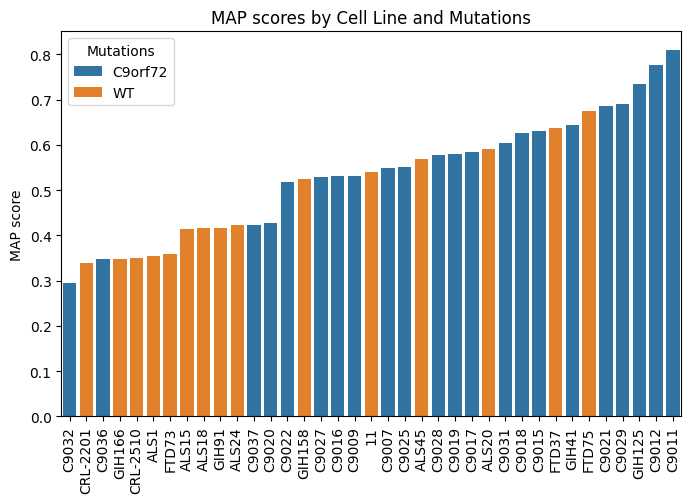

In [9]:
plt = map_analysis.make_fig()
plt.show()